In [31]:
# Load the video data 
import numpy as np
import skvideo.io
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from tqdm import tqdm
import pickle
%matplotlib inline

In [2]:
filename = "sample.mp4" 
frames_to_load = 7273 # this is necessary because it seems to crash at the end of the video 

all_data = skvideo.io.vread(filename, num_frames=frames_to_load)

print(all_data.shape)

(7273, 384, 384, 3)


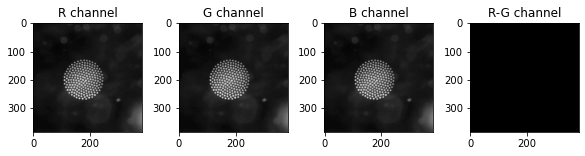

In [3]:
plt.figure(figsize=(10, 2))
plt.subplot(1, 4, 1)
plt.imshow(all_data[0, :, :, 0], "gray")
plt.title("R channel")
plt.subplot(1, 4, 2)
plt.imshow(all_data[0, :, :, 1], "gray")
plt.title("G channel")
plt.subplot(1, 4, 3)
plt.imshow(all_data[0, :, :, 2], "gray")
plt.title("B channel")
plt.subplot(1, 4, 4)
plt.imshow(all_data[0, :, :, 0] - all_data[0, :, :, 1], "gray")
plt.title("R-G channel")
plt.show()

In [4]:
# So all color channels contain the same data. I think we can safely drop all the extra channels. I also think we can crop a bit, maybe 50 pixels off each side.
crop = 50
data = all_data[:, crop:-crop, crop:-crop, 0]

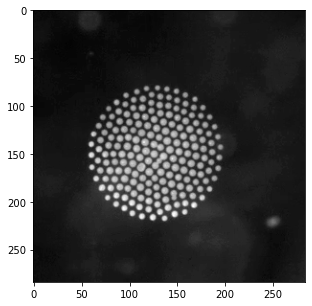

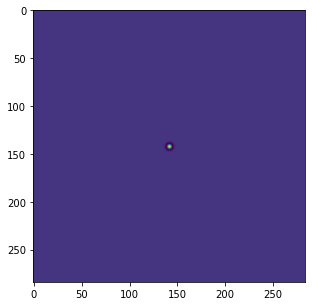

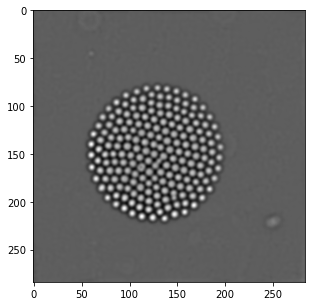

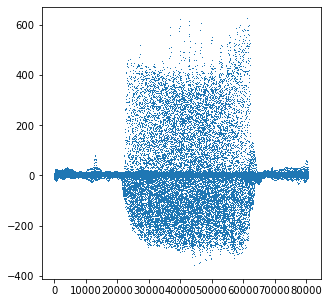

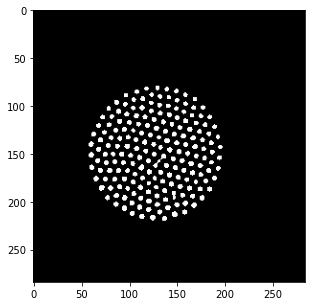

In [14]:
# let's try the top hat filter, per our discussion in class.

# filter_scale = 3.5 ## in pixels
# threshold = 1000
filter_scale = 3
threshold = 150

plt.figure(figsize=(5, 5))
plt.imshow(data[0, :, :], "gray")
plt.show()

[N, X, Y] = data.shape
x = np.arange(-X/2, X/2)
y = np.arange(-Y/2, Y/2)
#print(np.size(x),np.size(y))
x2d, y2d = np.meshgrid(y, x)
radius = np.sqrt(x2d**2 + y2d**2)
real_space_filter = np.exp(-2 * (radius / filter_scale)**2) * (1 - 2 * (radius / filter_scale)**4)
# real_space_filter = np.zeros_like(radius)
# real_space_filter[radius < filter_scale] = 1
# real_space_filter[np.logical_and(
#     radius > filter_scale, radius < filter_scale*np.sqrt(2))] = -1
plt.figure(figsize=(5, 5))
plt.imshow(real_space_filter)
plt.show()

fft_data = np.fft.fft2(data[0, :, :])
fourier_filter = np.fft.fft2(np.fft.fftshift(real_space_filter))
filtered = np.real(np.fft.ifft2(fft_data*fourier_filter))
plt.figure(figsize=(5, 5))
plt.imshow(filtered, "gray")
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(filtered.ravel(),",")
plt.show()

thresholded = np.copy(filtered)
thresholded[thresholded < threshold] = 0
thresholded[thresholded > 0] = 1
thresholded = np.asarray(thresholded, dtype=bool)
plt.figure(figsize=(5, 5))
plt.imshow(thresholded, "gray")
plt.show()

In [11]:
# try my dumbest method of particle assignment

raveled = thresholded.ravel()

def assign(i, particles):
    membership = []
    for j, p in enumerate(particles):
        if ((i - 1 in p) or (i - X + 1 in p) 
            or (i - X in p) or (i - X - 1 in p)):
            membership.append(j)
        
    if len(membership) == 0:
        particles.append([i])
    elif len(membership) == 1:
        particles[membership[0]].append(i)
    else:
        for j in membership[1:]:
            particles[membership[0]] += particles[j]
            del particles[j]

def m_to_xy(m):
    return np.mod(m, X), np.floor_divide(m, X)

M = X*Y
particles = []

for i in range(M):
    if raveled[i]:
        assign(i, particles)

for i, p in enumerate(particles):
    particles[i] = np.asarray(m_to_xy(p))

print(particles[0])

[[129 130 128 129 130 131 128 129 130 131 128 129 130 131]
 [ 79  79  80  80  80  80  81  81  81  81  82  82  82  82]]


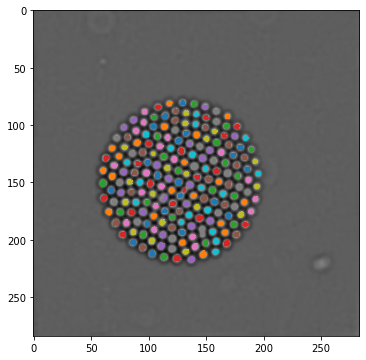

In [15]:
plt.figure(figsize=(6,6))

plt.imshow(filtered, "gray")
for p in particles:
    plt.plot(p[0], p[1], marker="," )
plt.show()
plt.show()

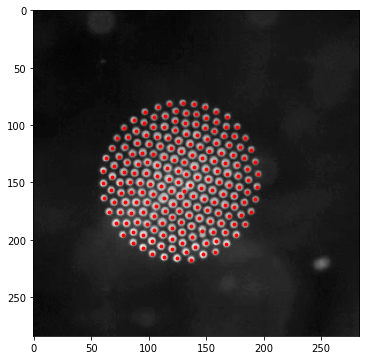

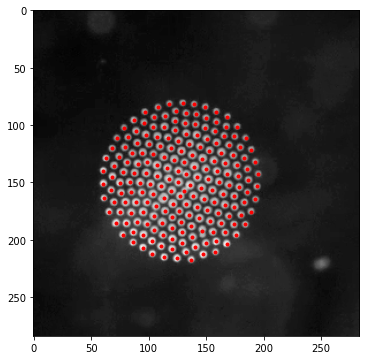

In [20]:
# compute centroids of each "particle", then go back to the original image and fit

def com(xy, d):
    return np.average(xy, axis=1, weights=d[xy[1, :], xy[0, :]])

initial_centers = np.transpose(np.asarray([com(p, filtered) for p in particles]))
plt.figure(figsize=(6,6))
plt.imshow(data[0, :, :], "gray")
plt.plot(initial_centers[0, :], initial_centers[1, :], 'r.')
plt.show()

initial_centers = np.transpose(np.asarray([com(p, data[0, :, :]) for p in particles]))
plt.figure(figsize=(6,6))
plt.imshow(data[0, :, :], "gray")
plt.plot(initial_centers[0, :], initial_centers[1, :], 'r.')
plt.show()

# def max2d(xy, d):
#     p = np.argmax(d[xy[1, :], xy[0, :]])
#     return np.asarray([xy[0, p], xy[1, p]])

# initial_centers = np.transpose(np.asarray([max2d(p, np.real(filtered)) for p in particles]))
# plt.figure(figsize=(6,6))
# plt.imshow(data[0, :, :], "gray")
# plt.plot(initial_centers[0, :], initial_centers[1, :], 'r.')
# plt.show()

In [21]:
# # let's now streamline the whole pipeline

# filter_scale = 3
# threshold = 150

# [N, X, Y] = data.shape
# x = np.arange(-X/2, X/2)
# y = np.arange(-Y/2, Y/2)

# x2d, y2d = np.meshgrid(y, x)
# radius = np.sqrt(x2d**2 + y2d**2)
# real_space_filter = np.exp(-2 * (radius / filter_scale)**2) * (1 - 2 * (radius / filter_scale)**4)
# fourier_filter = np.fft.fft2(np.fft.fftshift(real_space_filter))


# fft_data = np.fft.fft2(data, axes=[1, 2])
# filtered = np.real(np.fft.ifft2(fft_data*fourier_filter))

# thresholded = np.copy(filtered)
# thresholded[thresholded < threshold] = 0
# thresholded[thresholded > 0] = 1
# thresholded = np.asarray(thresholded, dtype=bool)


In [30]:
# allparticles = []
# for i in tqdm(range(N)):

#     raveled = thresholded[i, :, :].ravel()

#     def assign(i, particles):
#         membership = []
#         for j, p in enumerate(particles):
#             if ((i - 1 in p) or (i - X + 1 in p) 
#                 or (i - X in p) or (i - X - 1 in p)):
#                 membership.append(j)
            
#         if len(membership) == 0:
#             particles.append([i])
#         elif len(membership) == 1:
#             particles[membership[0]].append(i)
#         else:
#             for j in membership[1:]:
#                 particles[membership[0]] += particles[j]
#                 del particles[j]

#     def m_to_xy(m):
#         return np.mod(m, X), np.floor_divide(m, X)

#     M = X*Y
#     particles = []

#     for i in range(M):
#         if raveled[i]:
#             assign(i, particles)

#     for i, p in enumerate(particles):
#         particles[i] = np.asarray(m_to_xy(p))
    
#     allparticles.append(particles)

100%|██████████| 7273/7273 [32:03<00:00,  3.78it/s]


In [33]:
# pickle.dump(filtered, open("filtered.p", "wb"))
# pickle.dump(thresholded, open("thresholded.p", "wb"))
# pickle.dump(allparticles, open("allparticles.p", "wb"))

In [34]:
filtered = pickle.load(open("filtered.p", "rb"))
thresholded = pickle.load(open("thresholded.p", "rb"))
allparticles = pickle.load(open("allparticles.p", "rb"))